Titanic Dataset

1. Import & look at data
2. Prepare categorical data
3. Prepare numerical data
4. Create model
5. Train model
6. ???
7. Profit

# Utitlity functions

In [30]:
from keras import models
from keras import layers
from keras import backend

In [31]:
import matplotlib.pyplot as plt

def plot_this(epochs, training, validation, label): 
    
    plt.clf()
    
    trim = 10

    plt.plot(epochs[trim:], training[trim:], 'b', label=('Training '+label))
    plt.plot(epochs[trim:], validation[trim:], 'g', label=('Validation '+label))
    plt.title('Model ' + label)
    plt.xlabel('Epochs')
    plt.ylabel(label)
    plt.legend()

    plt.show()

In [32]:
def smooth_curve(points, factor=0.99):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Let's begin!

In [33]:
import pandas as pd 

titanic_path = '../../titanic/train.csv'

df = pd.read_csv(titanic_path, quotechar='"')

In [34]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Keep only desired rows and rearrange for easier view:

In [35]:
preferredOrder = ['Sex', 'Pclass', 'Cabin', 'Embarked', 'SibSp', 'Parch', 'Age', 'Fare', 'Survived']
df = df[preferredOrder]

In [36]:
df.head(3)

,Sex,Pclass,Cabin,Embarked,SibSp,Parch,Age,Fare,Survived
0,male,3,NaN,S,1,0,22.0,7.2500,0
1,female,1,C85,C,1,0,38.0,71.2833,1
2,female,3,NaN,S,0,0,26.0,7.9250,1


# Prepare categorical data

We will use these 4 as categories:
 - Sex
 - Pclass
 - Cabin
 - Embarked

In [37]:
categorical_data = preferredOrder[:4]
categorical_data

['Sex', 'Pclass', 'Cabin', 'Embarked']

`Cabin` values need to be placed into categories.

In [38]:
df['Cabin'].values[:20]

array([nan, 'C85', nan, 'C123', nan, nan, 'E46', nan, nan, nan, 'G6',
       'C103', nan, nan, nan, nan, nan, nan, nan, nan], dtype=object)

In [39]:
def cleanCabin(el):
    if isinstance(el, str):
        return el[:1]
    else:
        return '0'
df['Cabin'] = df['Cabin'].apply(cleanCabin)
df['Cabin'].values[:20]

array(['0', 'C', '0', 'C', '0', '0', 'E', '0', '0', '0', 'G', 'C', '0',
       '0', '0', '0', '0', '0', '0', '0'], dtype=object)

Keras has `to_categorical` method for **one hot encoding** of data, but it requires natural number input.

We will create our own conversion

In [40]:
def convert_to_natural_number(x, temp_dict):
    if x in temp_dict:
        return temp_dict[x]
    else:
        temp_dict[x] = temp_dict['curr_count']
        temp_dict['curr_count'] += 1
        return temp_dict[x]


In [41]:
def categorical_column_to_number(col):
    temp_dict = temp_dict = {'curr_count': 0}
    df[col] = df[col].apply(convert_to_natural_number, args=(temp_dict,))

In [42]:
df[categorical_data].head(10)

,Sex,Pclass,Cabin,Embarked
0,male,3,0,S
1,female,1,C,C
2,female,3,0,S
3,female,1,C,S
4,male,3,0,S
5,male,3,0,Q
6,male,1,E,S
7,male,3,0,S
8,female,3,0,S
9,female,2,0,C


In [43]:
for col in categorical_data:
    categorical_column_to_number(col)

In [44]:
df[categorical_data].head(10)

,Sex,Pclass,Cabin,Embarked
0,0,0,0,0
1,1,1,1,1
2,1,0,0,0
3,1,1,1,0
4,0,0,0,0
5,0,0,0,2
6,0,1,2,0
7,0,0,0,0
8,1,0,0,0
9,1,2,0,1


Now we are ready to convert data to _one hot encoding_

In [46]:
newDF = pd.DataFrame()
newDF = df[categorical_data]
    
for col in categorical_data:
    one_hot = pd.get_dummies(df[col])
    one_hot = one_hot.add_prefix(col)
    newDF = newDF.join(one_hot) #adding onehot encoded columns to dataframe
    newDF = newDF.drop(col, 1) #deleting categorical column

In [47]:
newDF.head(5)

,Sex0,Sex1,Pclass0,Pclass1,Pclass2,Cabin0,Cabin1,Cabin2,Cabin3,Cabin4,Cabin5,Cabin6,Cabin7,Cabin8,Embarked0,Embarked1,Embarked2,Embarked3
0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0


In [48]:
newDF.shape

(891, 18)

In [49]:
backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(36, activation='relu', input_shape=(18,)))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(8, activation='relu'))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(4, activation='relu'))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 36)                684       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 296       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________


In [50]:
x_data = newDF
y_data = df['Survived']

cutoff = round(0.8 * len(x_data))

x_train = x_data[:cutoff]
y_train = y_data[:cutoff]

x_validation = x_data[cutoff:]
y_validation = y_data[cutoff:]

# Prepare numerical data

We will use these 4 as numbers:
 - SibSp (# of **sib**lings / # of **sp**ouses)
 - Parch (# of **par**ent / # of **ch**ildren)
 - Age
 - Fare

In [17]:
numerical_data = preferredOrder[4:8]
numerical_data

['SibSp', 'Parch', 'Age', 'Fare']

In [18]:
import math

def normalize(x, colMax):
    if math.isnan(x):
        return 0
    if isinstance(x, float):
        return x / colMax
    elif isinstance(x, int):
        return float(x) / colMax
    else:
        return 0

In [19]:
def applyNormalize(col):
    column_max = df[col].max()
    df[col] = df[col].apply(normalize, args=(column_max,))

In [20]:
for col in numerical_data:
    applyNormalize(col)

In [21]:
df[numerical_data].head(3)

,SibSp,Parch,Age,Fare
0,0.125,0.0,0.275,0.014151
1,0.125,0.0,0.475,0.139136
2,0.000,0.0,0.325,0.015469


In [22]:
df[numerical_data].describe()

,SibSp,Parch,Age,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,0.065376,0.063599,0.297491,0.062858
std,0.137843,0.134343,0.219951,0.096995
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.075000,0.015440
50%,0.000000,0.000000,0.300000,0.028213
75%,0.125000,0.000000,0.437500,0.060508
max,1.000000,1.000000,1.000000,1.000000


Notice that max is now 1

# Build model

In [23]:
df.head(10)

,Sex,Pclass,Cabin,Embarked,SibSp,Parch,Age,Fare,Survived
0,0,0,0,0,0.125,0.000000,0.2750,0.014151,0
1,1,1,1,1,0.125,0.000000,0.4750,0.139136,1
2,1,0,0,0,0.000,0.000000,0.3250,0.015469,1
3,1,1,1,0,0.125,0.000000,0.4375,0.103644,1
4,0,0,0,0,0.000,0.000000,0.4375,0.015713,0
5,0,0,0,2,0.000,0.000000,0.0000,0.016510,0
6,0,1,2,0,0.000,0.000000,0.6750,0.101229,0
7,0,0,0,0,0.375,0.166667,0.0250,0.041136,0
8,1,0,0,0,0.000,0.333333,0.3375,0.021731,1
9,1,2,0,1,0.125,0.000000,0.1750,0.058694,1


**Randomize the order of all the rows**

_this is important because the original data may not be (and in this case is not) random_

In [32]:
df = df.sample(frac=1)

Split validation & training data

In [33]:
x_data = df[numerical_data]
y_data = df['Survived']

cutoff = round(0.8 * len(x_data))

x_train = x_data[:cutoff]
y_train = y_data[:cutoff]

x_validation = x_data[cutoff:]
y_validation = y_data[cutoff:]

In [63]:
backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4,)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total para

In [51]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=600, 
                    batch_size=len(x_train),
                    verbose=0,
                    validation_data=(x_validation, y_validation))

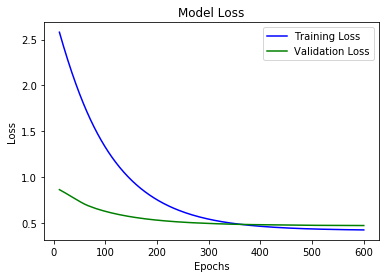

In [52]:
loss = smooth_curve(history.history['loss'])
val_loss = smooth_curve(history.history['val_loss'])

epochs = range(1, len(loss) + 1)

plot_this(epochs, loss, val_loss, 'Loss')

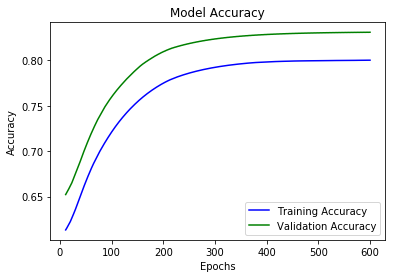

In [53]:
accuracy = smooth_curve(history.history['acc'])
val_acc = smooth_curve(history.history['val_acc'])

plot_this(epochs, accuracy, val_acc, 'Accuracy')

# Archived

In [154]:
from keras.utils import to_categorical

In [185]:
for col in categorical_data:
    print(col)
    lol = np.array(to_categorical(df[col]))
#     d = {'Sex': lol}
#     df2 = pd.DataFrame(data=d)
#     np.reshape(lol)
    print(lol[:5])

Sex
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]
Pclass
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]
Cabin
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]]
Embarked
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  0.]]
